Osnabrück University - Computer Vision (Winter Term 2016/17) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack

# Exercise Sheet 06: Color Segmentation and Hough Transform

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, January 8, 2017**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Eigenvectors and Eigenvalues) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is an eigenvector of a matrix/a linear mapping? What are eigenvalues?

**b)** What is the characteristic polynomial of a matrix? How is it related to eigenvalues? What are algebraic and geometric multiplicity of an eigenvalue?

**c)** What is the spectrum of a matrix? What does the spectral theorem state?

## Assignment 1: $k$-means segmentation [8 Points]


**a)** Explain the idea of $k$-means clustering and how it can be used for segmentation.

**b)** Implement k-means clustering for color segmentation of an RGB image (no use of `scipy.cluster.vq.kmeans` or similar functions allowed here, but you may use functions like `numpy.mean`, `scipy.spatial.distance.pdist` and similar utility functions). Stop calculation when center vectors do not change more than a predefined threshold. Avoid empty clusters by re-initializing the corresponding center vector.

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Iterations: 1001


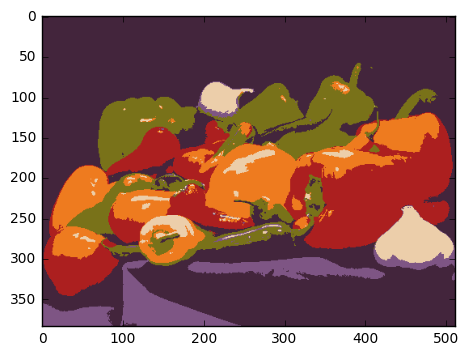

In [2]:
import numpy as np
import numpy.random as random
from scipy.spatial.distance import cdist
from scipy import misc
import matplotlib.pyplot as plt
from skimage import color, measure

def batch_euclid(X,Y, channels):
    return np.sqrt(np.sum(np.square(X[:,channels] - Y[:,channels]), axis=1))

def kmeans(img, k, channels=np.array([0,1,2])):
    h, w, c = img.shape
    img_flat = np.reshape(img, (h*w, 3))
    epsilon = 1 # one rgb value minimal motion
    previous = random.uniform(low=img.min(), high=img.max(), size=(k,3))
    centers = previous.copy()
    iter = 1
    labels = np.empty(img.shape)

    while True:
        pairwise_dists = cdist(img_flat, previous)
        min_indices = np.argmin(pairwise_dists, axis=1)
        labels = np.reshape(min_indices, (h, w))

        previous = centers.copy()
        for kluster in np.arange(k):
            centers[kluster,:] = img[labels == kluster].mean(axis=0)
            if not np.any(labels == kluster):
                centers[kluster,:] = random.uniform(img.min(), img.max(), 3)
        distances = batch_euclid(centers, previous, channels)
        if (not np.any(distances > epsilon)) or iter > 1000:
            break
        else:
            iter += 1

    print("Iterations: %d" % iter)
    return centers, labels

# this has been found to give a good result, but uses all 1000 iters
random.seed(2)

image = misc.imread('peppers.png')
k = 6
centers, labels = kmeans(image, k)
for label in np.arange(k):
    image[labels == label] = centers[label]
    
plt.imshow(image)
plt.show()

**c)** Apply your $k$-means algorithm (or some algorithm from `scipy`) to the image `peppers.png`. Label regions based on the color clusters (regions should be 4- or 8-connected). (Empirically) evaluate the result and find a good value for $k$.

Iterations: 2


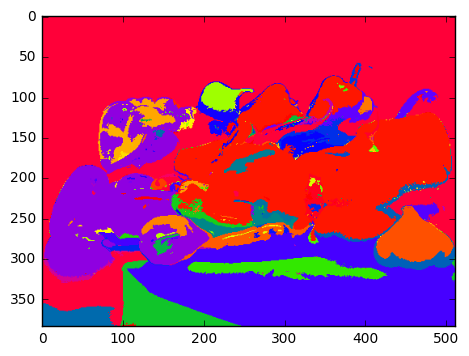

In [3]:
# Is this what is meant?
def label_image(cluster_img, k, n=4):
    labels = np.zeros(cluster_img.shape)
    count = 0
    for c in range(k):
        cluster_img_c = cluster_img == c
        labels_c, n_components = measure.label(cluster_img_c, neighbors=n,
                return_num=True)
        labels += (cluster_img_c * count) + labels_c
        count += n_components
    return labels.astype(np.int) - 1


image = misc.imread('peppers.png')
k = 6
centers, labels = kmeans(image, k)
image = label_image(labels, k, 8)

plt.imshow(image, cmap='prism')
plt.show()


**d)** Now do the same in the HSV space (remember its special topological structure). Check if you can improve the results by ignoring some of the HSV channels.

# Hä?

## Assignment 2: Evaluation of segmentation [4 Points]

**a)** What are desirable featues of a good segmentation? Can they be detected automatically? What is measured by the saliency function?

**b)** Implement the the automatic evaluation method from the lecture (CV-07 slides 112ff). Apply it to the segmentation from Assignment 1 and compare the results with your empirical observations.

In [1]:
def boundary(obj_image):
    return obj_image ^ binary_erosion(obj_image)

# I have no idea if this does the right thing. How do I best evaluate this?
def region_saliency(image, labels):
    """Labels must be consecutive with no unused ones in between"""
    regions = np.unique(labels)
    C_k = np.zeros((regions.size, 3))
    for R_i in regions:
        C_k[R_i, :] = np.average(image[labels == R_i,:], axis=0)
    S_R = np.zeros(regions.size)
    for R_i in regions:
        B = boundary(labels == R_i)
        boundary_idx = np.argwhere(B)
        for x,y in boundary_idx:
            N_4 = [(i,j) for i,j in [(x+1,y), (x,y+1), (x-1,y), (x,y-1)]
                    if i >= 0 and i < image.shape[0] 
                    and j >= 0 and j < image.shape[1]]
            neighbor_regions = [labels[idx] for idx in N_4]
            N_diff = (neighbor_regions != R_i).sum()
            s2 = sum(np.linalg.norm(C_k[R_j,:]-C_k[R_i,:]) for R_j in
                    neighbor_regions)
            if N_diff > 1:
                S_R[R_i] += 1/N_diff * s2
        S_R[R_i] /= 1/B.size
    return S_R


## Assignment 3: Hough transform [8 Points]

**a)** Explain in your own words the idea of Hough transform. What is an accumulator space? In what sense can the Hough transform be seen as a model-based approach?

**b)** What is linear Hough transform? How are points, lines, polygons transformed? What about parallel lines? Try different configurations using the functions `point`, `line`, `polygon` below. Then implement your own version of linear Hough transform and compare the results with the function `skimage.transform.hough_line`.

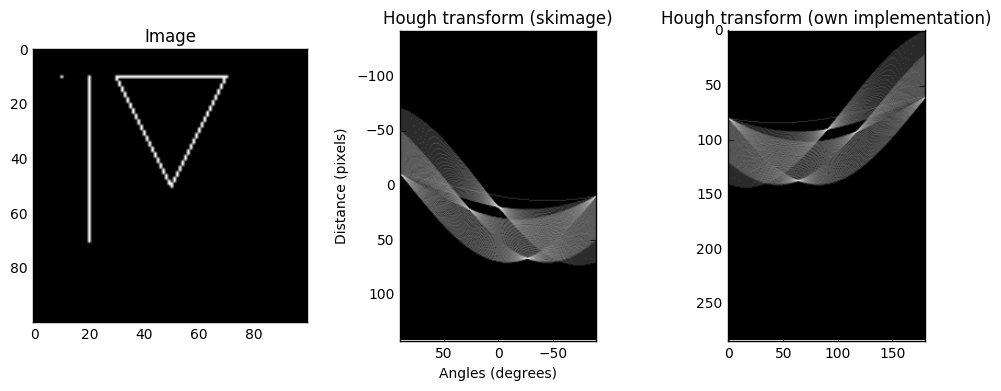

In [1]:
from skimage.transform import hough_line
import matplotlib.pyplot as plt
import numpy as np
import operator

steps = lambda p,q : max(map(lambda x,y: abs(x-y), p, q))+1
coords = lambda p,q,s : [np.linspace(x,y,s,dtype=np.uint16) for x,y in zip(p,q)]

def point(img, p):
    "Insert a point in the black/white image at position p"
    img[p] = 1

def line(img, p, q):
    "Insert a line from p to q in the black/white image"
    img[coords(p,q,steps(p,q))] = 1

def polygon(img, vertices):
    "Insert a (closed) polygon given by a list of points into the black/white image"
    for p, q in zip(vertices, vertices[1:]+vertices[0:1]):
        line(img,p,q)


def my_hough_line(img, angles=180):
    """
    Apply linear Hough transform to the given image.
    """
    d_max = int(np.ceil(np.sqrt(sum(map(np.multiply,img.shape,img.shape)))))
    accumulator = np.zeros((2*d_max, angles), np.uint64)
    thetas = np.linspace(0, angles-1, angles, dtype=np.int)
    thetas_rad = np.deg2rad(thetas)
    cos_theta = np.cos(thetas_rad)
    sin_theta = np.sin(thetas_rad)

    edge_pts = np.argwhere(img)
    for x, y in edge_pts:
        d = x * cos_theta + y * sin_theta
        d_idx = np.round(d).astype(np.int) + d_max // 2
        accumulator[d_idx, thetas] += 1

    return accumulator



img = np.zeros((100,100))


# You may try different paintings here:
point(img, (10,10))
line(img,(10,20),(70,20))
polygon(img,[(10,30),(50,50),(10,70)])



plt.figure(figsize=(12, 4))
plt.gray()
plt.subplot(1,3,1) ; plt.title('Image'); plt.imshow(img)

out, angles, d = hough_line(img)
plt.subplot(1,3,2) ; plt.title('Hough transform (skimage)');
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')
plt.imshow(np.log(1 + out), extent=[np.rad2deg(angles[-1]), np.rad2deg(angles[0]), d[-1], d[0]])

my_out = my_hough_line(img)
plt.subplot(1,3,3) ; plt.title('Hough transform (own implementation)');
plt.imshow(np.log(1+my_out))
plt.show()

**c)** What does a point in the linear Hough space represent? Under which conditions is (linear) Hough transform invertible? Try to implement an inverse linear Hough transform.

In [ ]:
from skimage.transform import hough_line
import matplotlib.pyplot as plt
import numpy as np
import operator

        
def my_inverse_hough_line(accumulator, shape):
    """
    Compute an inverse Hough transform, i.e. compute the image from the accumulator space.
    """
    img = np.zeros(shape, np.uint64)
    
    # FIXME: put your code here!

    return img

img = np.zeros((100,100))

#point(img, (10,10))
#line(img,(10,20),(70,20))
polygon(img,[(10,30),(50,50),(10,70)])


plt.figure(figsize=(12, 4))
plt.gray()
plt.subplot(1,3,1) ; plt.title('Image'); plt.imshow(img)

out, angles, d = hough_line(img)
plt.subplot(1,3,2) ; plt.title('Hough transform (skimage)');
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')
plt.imshow(np.log(1 + out), extent=[np.rad2deg(angles[-1]), np.rad2deg(angles[0]), d[-1], d[0]])

img2 = my_inverse_hough_line(out, img.shape)
plt.subplot(1,3,3) ; plt.title('Inverse Hough transform');
plt.imshow(img2)
plt.show()

**d)** Implement circular hough transform. First think how the accumulator space should be represented. You may provide an additional parameter to only look for circles of a given radius (or a range of radii). Then apply it to the image `xmas.png` to detect the balls. Mark them in the original image. (Bonus task: also detect the presents using linear Hough transform).

In [1]:
# FIXME: put your code here!
